<a href="https://colab.research.google.com/github/BenCashman/AmazonProduct-Sentiment-Analysis/blob/master/AMZ_Products_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq transformers

     |████████████████████████████████| 675kB 4.6MB/s 
     |████████████████████████████████| 3.8MB 25.1MB/s 
     |████████████████████████████████| 1.1MB 45.5MB/s 
     |████████████████████████████████| 890kB 45.7MB/s 


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from torch.nn import functional as F
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


#Lets ingest our data into our server for data exploration training and model delivery
df = pd.read_csv('https://amazonproductdata.s3-us-west-1.amazonaws.com/train.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
'''
import transformers

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pp
from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup


#import sklearn important functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix #needed for classification problems
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve #receiver operating charecteristic curve for binary classifier model diagnosis
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from torch import nn, optim

#import python based open-source system for mathematical , science and engineering functions
import scipy 

import time
import numpy as np

#Lets ingest our data into our server for data exploration training and model delivery
df = pd.read_csv('https://amazonproductdata.s3-us-west-1.amazonaws.com/train.csv')

'''



"\nimport transformers\n\nimport torch\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nimport pandas_profiling as pp\nfrom sklearn import svm\nfrom sklearn.datasets import make_moons, make_blobs\nfrom sklearn.covariance import EllipticEnvelope\nfrom sklearn.ensemble import IsolationForest\nfrom sklearn.neighbors import LocalOutlierFactor\nfrom sklearn.cluster import DBSCAN\nfrom transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup\n\n\n#import sklearn important functions\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import mean_squared_error, r2_score\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import confusion_matrix #needed for classification problems\nfrom sklearn.metrics import classification_report\nfrom sklearn.metrics import roc_curve #receiver operating charecteristic curve for binary classifier model diagnosis\nfrom sklearn.metrics import roc_auc_score\nfr

In [0]:
#First look at the data
df.head(15)
df = df.sample(2000)

In [5]:
#See our column names
list(df.columns)

['polarity', 'review_subject', 'review_body']

In [6]:
#Another quick overview of our data
df.describe

<bound method NDFrame.describe of        polarity  ...                                        review_body
75721         2  ...  I have read all of Patricia Cornwell's books. ...
80184         2  ...  Lively and danceable, fun African music: Souko...
19864         2  ...  Recently purchased a jar of this from a shoe s...
76699         2  ...  This is a great dvd for the Def Leppard fan. I...
92991         2  ...  I thought Carrie was both an awesome movie and...
...         ...  ...                                                ...
58380         2  ...  I Loved this movie when I was a kid, what a wo...
44243         2  ...  The vest is fine and it is constructed like th...
8745          2  ...  Definitely my favorite band. We saw 4 hits com...
96758         2  ...  I know a book is good when I come to the end o...
45067         2  ...  "Solitude" is a stunningly good album - warm, ...

[2000 rows x 3 columns]>

In [7]:
#Null analysis - seems our data has 3 nulls in the subject section!
df.isna().sum()

polarity          0
review_subject    1
review_body       0
dtype: int64

In [0]:
#Let's drop the 3 null rows
df.dropna(inplace=True)

In [9]:
#Now let's see how many rows and cloumns we have (#rows, #columns)
df.shape

(1999, 3)

In [10]:
#let's take one more look at our data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1999 entries, 75721 to 45067
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   polarity        1999 non-null   int64 
 1   review_subject  1999 non-null   object
 2   review_body     1999 non-null   object
dtypes: int64(1), object(2)
memory usage: 62.5+ KB


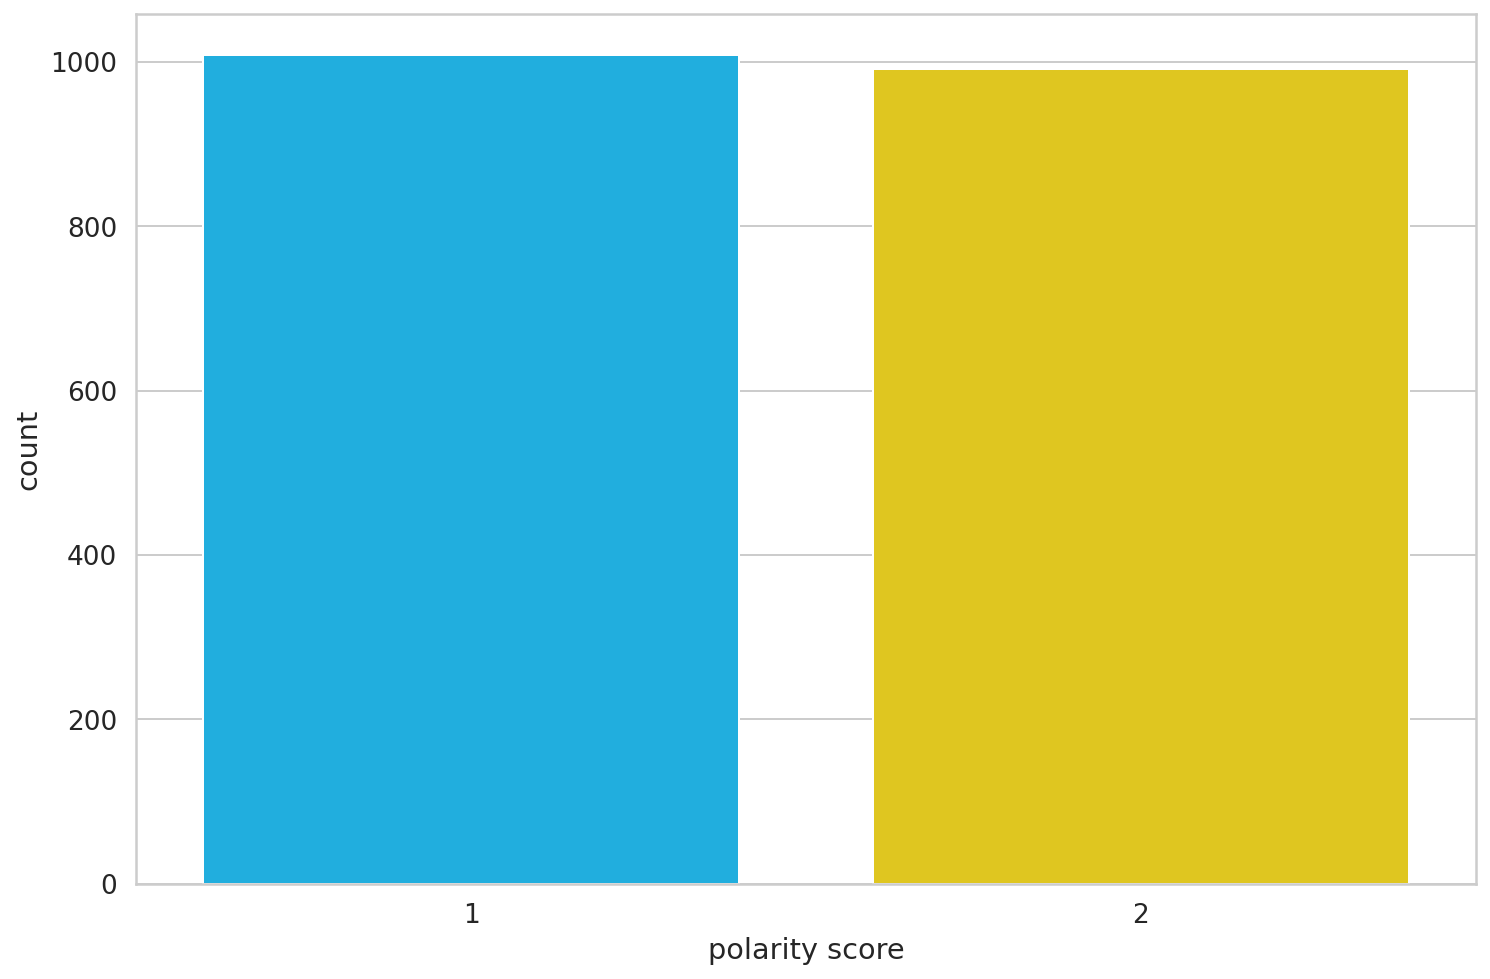

In [11]:

#let's take a look at our polarity to see if there is any imbalance
#Based on our data is looks like we have a few more positive sentiment scores but nothing to worry about
sns.countplot(df.polarity)
plt.xlabel('polarity score');

In [0]:
def to_sentiment(rating):
  rating = int(rating)
  if rating == 1:
    return 0
  else: 
    return 1

df['sentiment'] = df.polarity.apply(to_sentiment)

In [0]:
class_names = ['negative', 'positive']

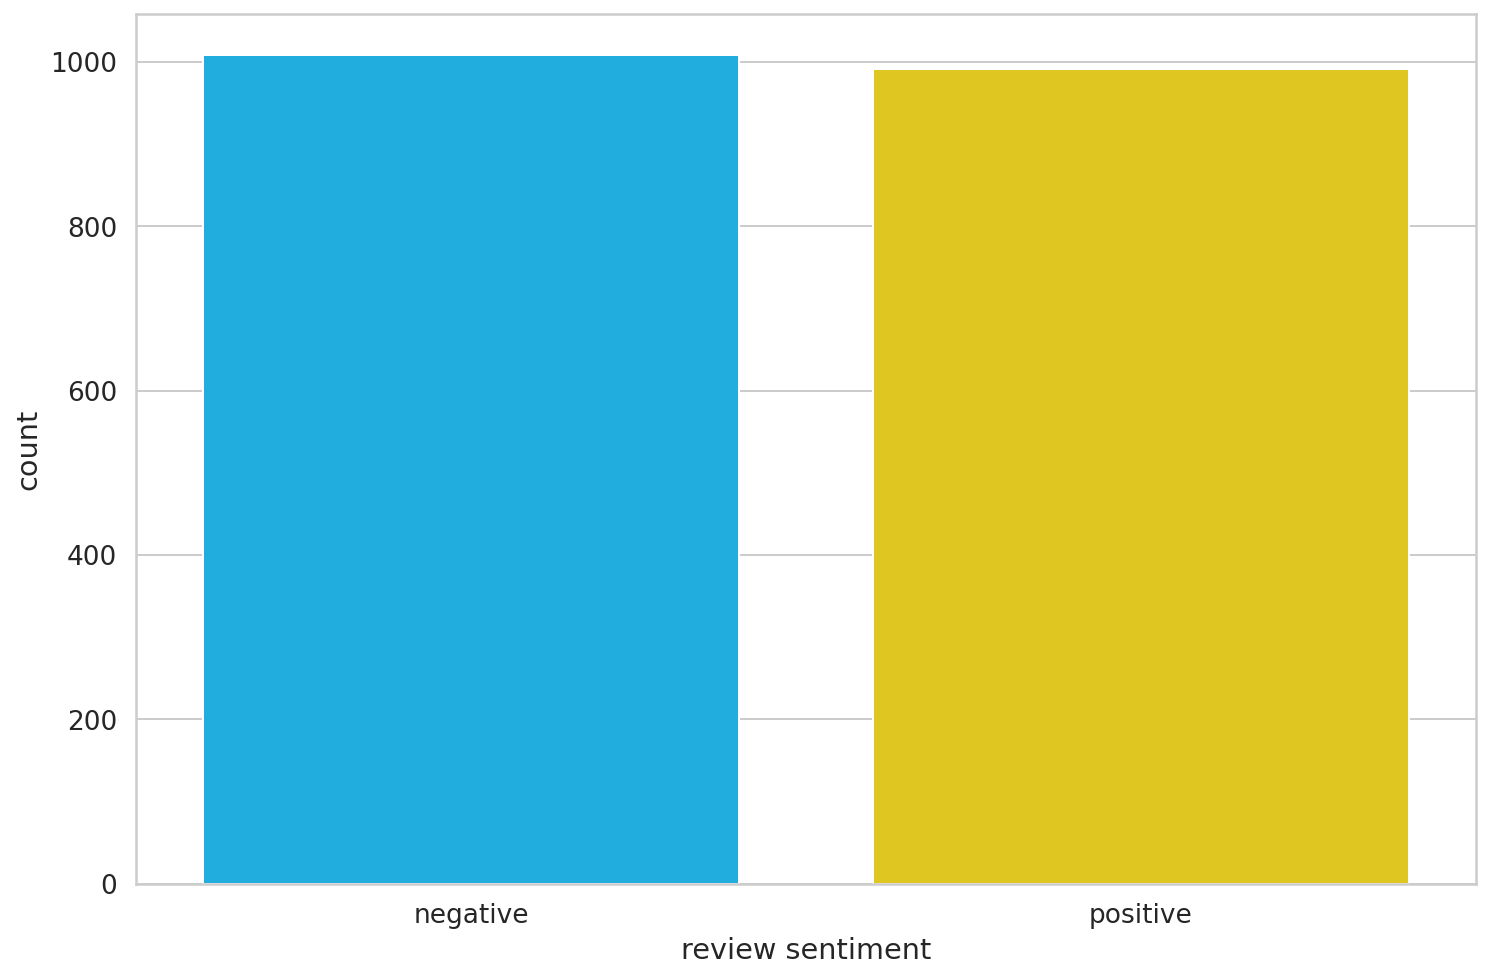

In [14]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [0]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [16]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Sample sentence string to demonstrate token conversion

In [0]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'


Here we will demonstrate what the tokenized versions of the words are

In [18]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


SEP tokens are utilized to mark the ending of a sentence

In [19]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

Here is the token for the start of a sentence

In [20]:
tokenizer.cls_token, tokenizer.cls_token_id


('[CLS]', 101)

This will be the token for padding

In [21]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

Finally we have an Uknown token


In [22]:
tokenizer.unk_token, tokenizer.unk_token_id


('[UNK]', 100)

These tokens will be added and implemented to our data set using the encode_plus() method

In [23]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

By running the method our token ids are now stored in a Tensor and padded to a length of 32

In [24]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

Now we can take a look at the attention mask

In [25]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

Let's take a look at the special tokens in action - inverse

In [26]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])



['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Up next we will choose our sequence length

In [0]:
token_lens = []
for txt in df.review_body:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Now let's take a look and see our token size distribution

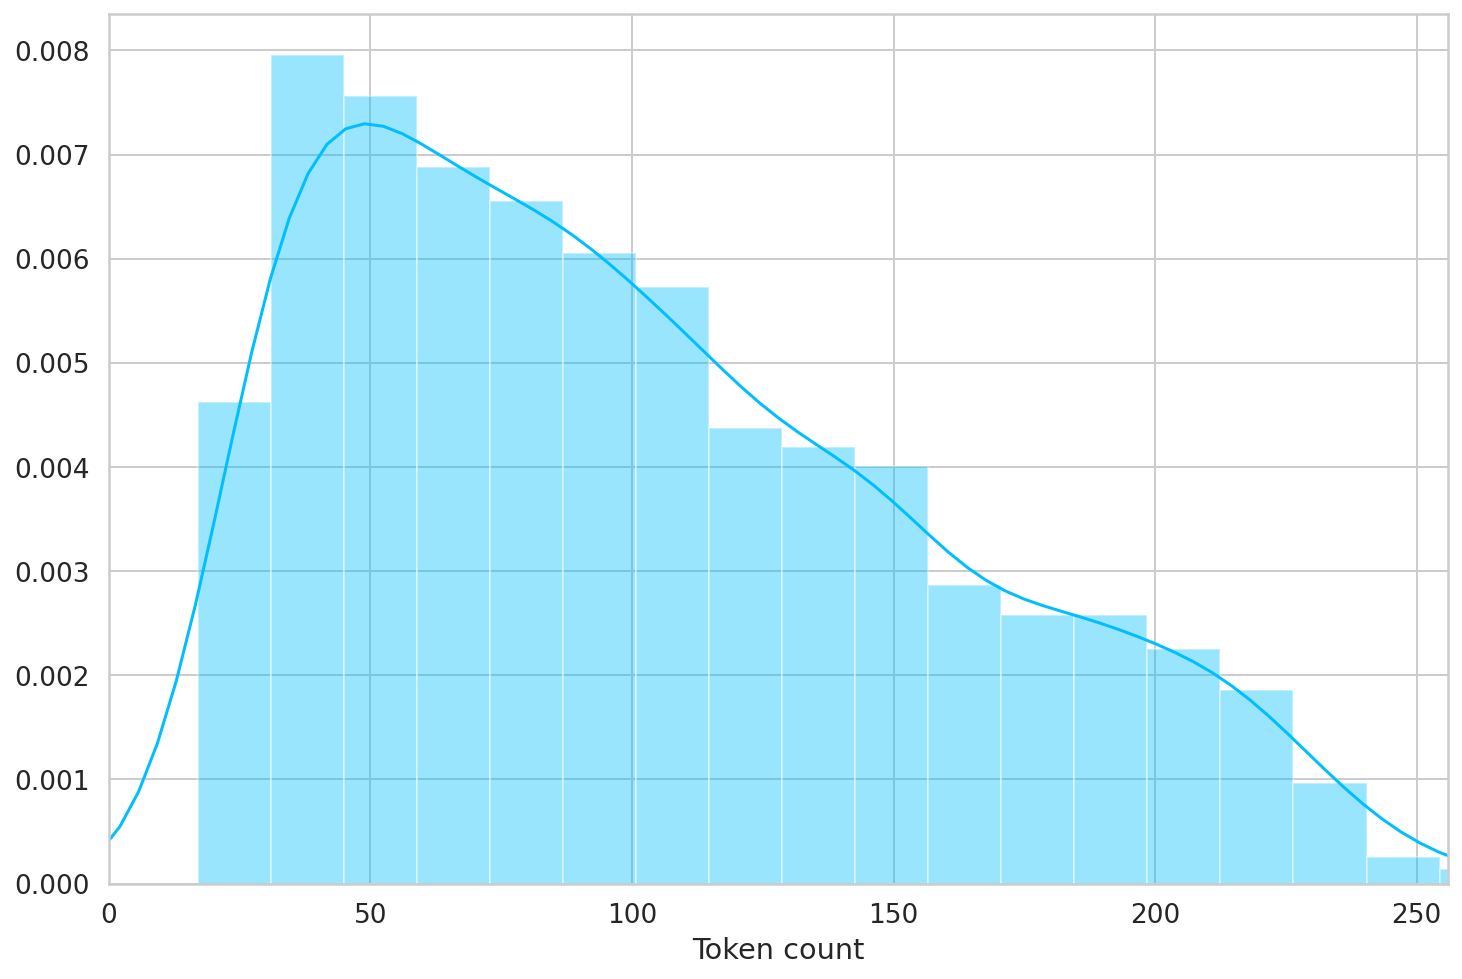

In [28]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Seeing as most our tokens go up to 250 - we'll be safe and make the max number 260

In [0]:
MAX_LEN = 300

Now that we've explored our data set we can generate our PyTorch dataset.

In [0]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Up next we will split our data and let the Tokenizer do it's magic.

In [0]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

Take a peak at the data shapes

In [32]:
df_train.shape, df_val.shape, df_test.shape


((1799, 4), (100, 4), (100, 4))

Up next let's create our data loaders

In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review_body.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )


Now we will assign the batch size - let's make it small to start

In [0]:
BATCH_SIZE = 2

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Up next we can see an example batch right out of our data loader.

In [35]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [36]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([2, 300])
torch.Size([2, 300])
torch.Size([2])


Up next we'll load the basic BERT pretrained model

In [37]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Now we can try it out on our sample text from earlier

In [0]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

Let's also apply the Last_hidden_state which is a sequence of in the last layer of our model. Obtaining the pooled_output will be dont by applying the BertPooler on last_hidden_state

In [39]:
last_hidden_state.shape


torch.Size([1, 32, 768])

Next let's check our configuration

In [40]:
bert_model.config.hidden_size



768

Let's take a look at the shape for the pooled *output*

In [41]:
pooled_output.shape

torch.Size([1, 768])

Here is a helper function to generate a classifier that uses the BERT model

In [0]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Time to move the PyTorch model on over to the GPU

In [0]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We will also move the example batch of training data to the GPU

In [44]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([2, 300])
torch.Size([2, 300])


To generate predictded probabilities we will now apply a softmax function

In [45]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.7072, 0.2928],
        [0.7760, 0.2240]], device='cuda:0', grad_fn=<SoftmaxBackward>)

Time to set up for training! Here we will use the AdamW optimizer which is from the Hugging Face library. Adam is usefull for correcting weight decay. Additionally as we are doing classificaiton we will utilize cross entropy loss for our loss function.

In [0]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

Next - we add a helper function to train our model for an epoch

In [0]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

Now using the two helper functions we've generated we can make a training loop

In [49]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.7579603529969852 accuracy 0.7359644246803779
Val   loss 0.37663356244564056 accuracy 0.91

Epoch 2/5
----------
Train loss 0.4285366311338213 accuracy 0.9182879377431906
Val   loss 0.5771235775947571 accuracy 0.9

Epoch 3/5
----------
Train loss 0.17882203994525803 accuracy 0.9699833240689272
Val   loss 0.6389431643486023 accuracy 0.9

Epoch 4/5
----------
Train loss 0.08118041806750827 accuracy 0.9877709838799332
Val   loss 0.5766880178451538 accuracy 0.92

Epoch 5/5
----------
Train loss 0.049820541342099504 accuracy 0.9927737632017787
Val   loss 0.600138441324234 accuracy 0.92

CPU times: user 7min 28s, sys: 1min, total: 8min 29s
Wall time: 8min 31s


Here we can plot our training accuracy vs our validation accuracy

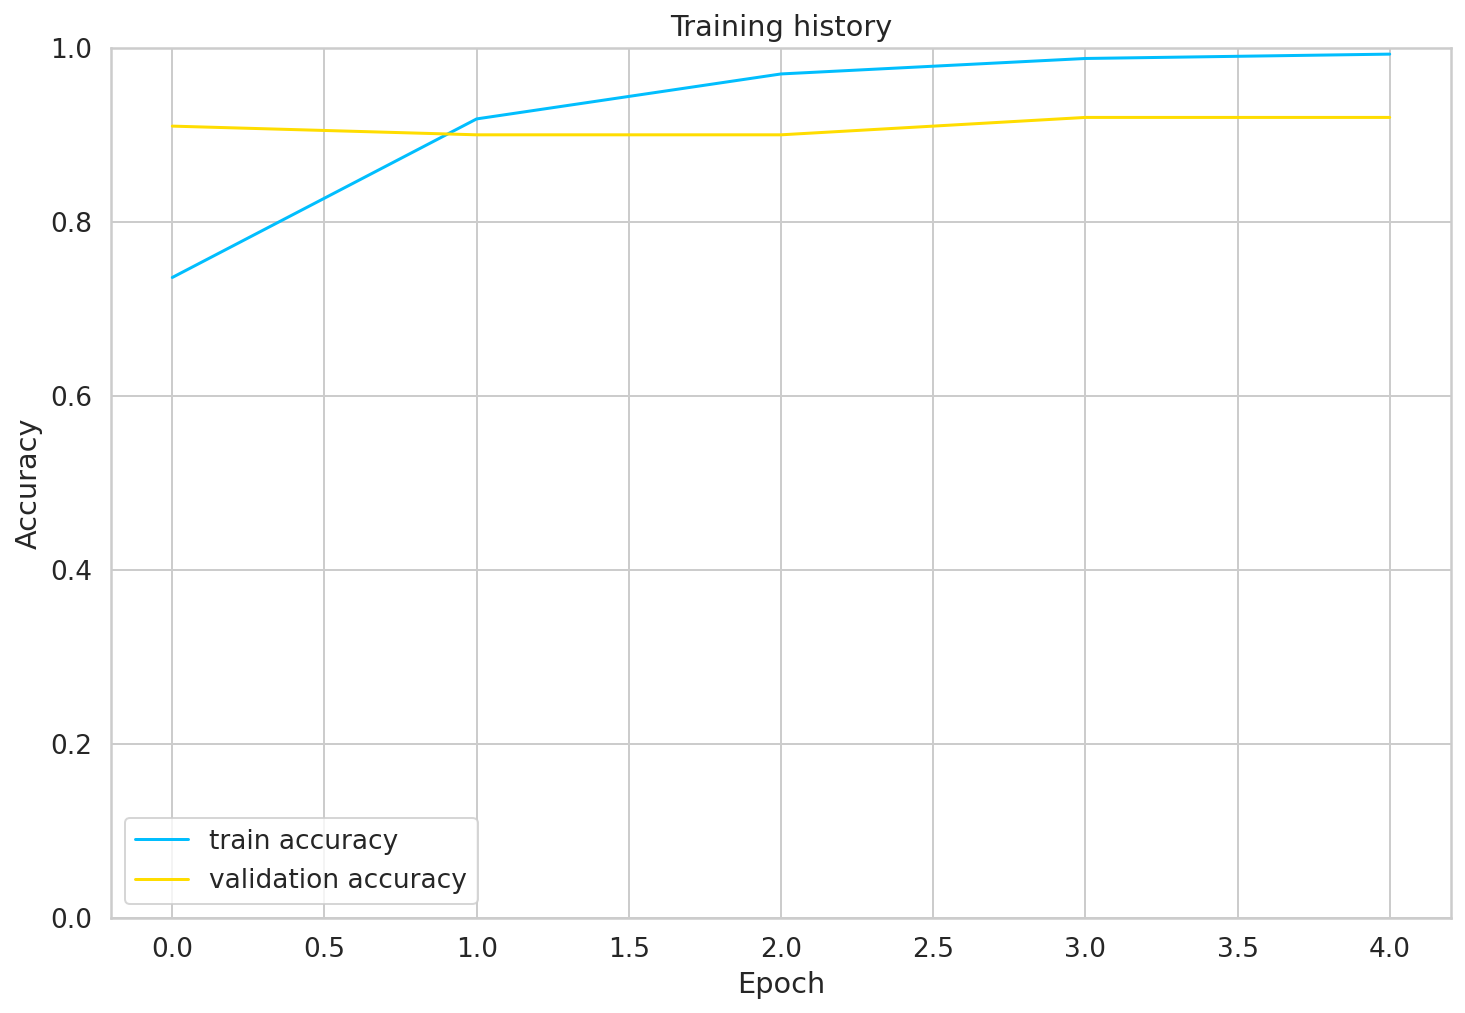

In [69]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);


Let's now go deeper into our model evaluation, looking at test data.

In [70]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.91

Seemingly we can be pretty happy with 91% accuracy, lets now create a helper function to obtain predictions.


In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

Next we will add the ability to store the text of the reviews along with their probabilities:

In [0]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)


Here is our Classification report

In [73]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.90      0.92      0.91        49
    positive       0.92      0.90      0.91        51

    accuracy                           0.91       100
   macro avg       0.91      0.91      0.91       100
weighted avg       0.91      0.91      0.91       100



Next, we will plot a confusion matrix:


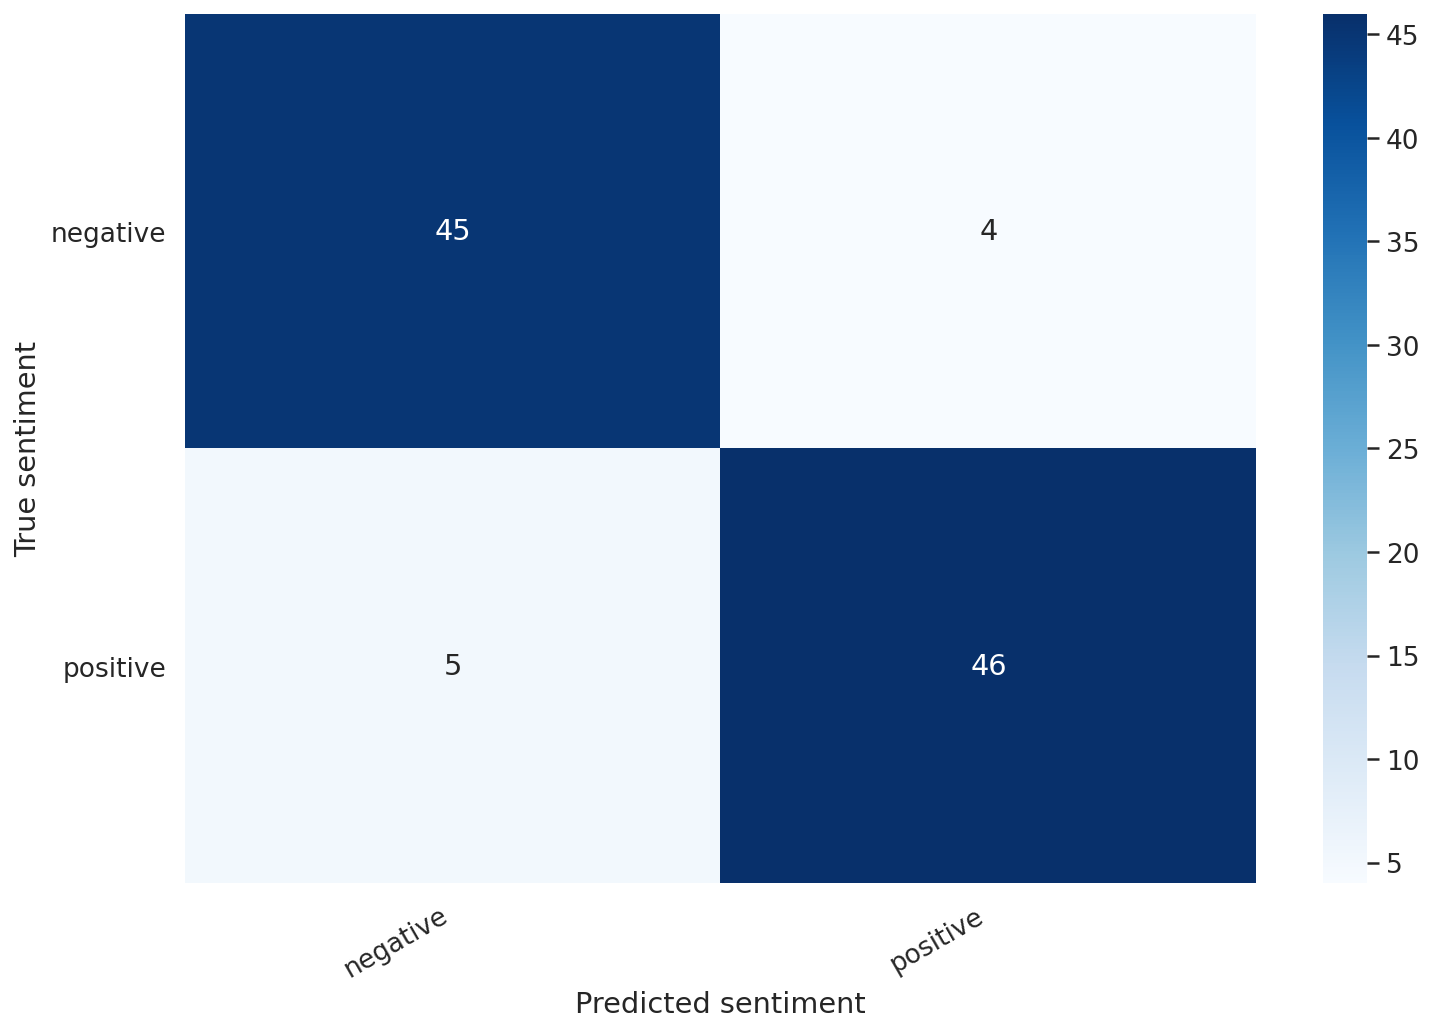

In [74]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Here we will take a look again at model performing inference on a single piece of data from our test data:

In [0]:
#loading in data from the 3rd index
idx = 3
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [76]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I got these as a gift and really do like them. I just stick them to
the fridge (magnets) and always know where they are. They are easy to
use altho I do find they release less salt or pepper than you first
think....so you have to squeeze more times than you normally would. It
takes some getting used to.This is very handy to have, easy to use and
its nice to have a small set to pass around at the table. I am also
glad you can graind the salt...some sets are for grinding pepper but
not the salt.

True sentiment: positive


Now another look at the confidence for each stntiment of our model:

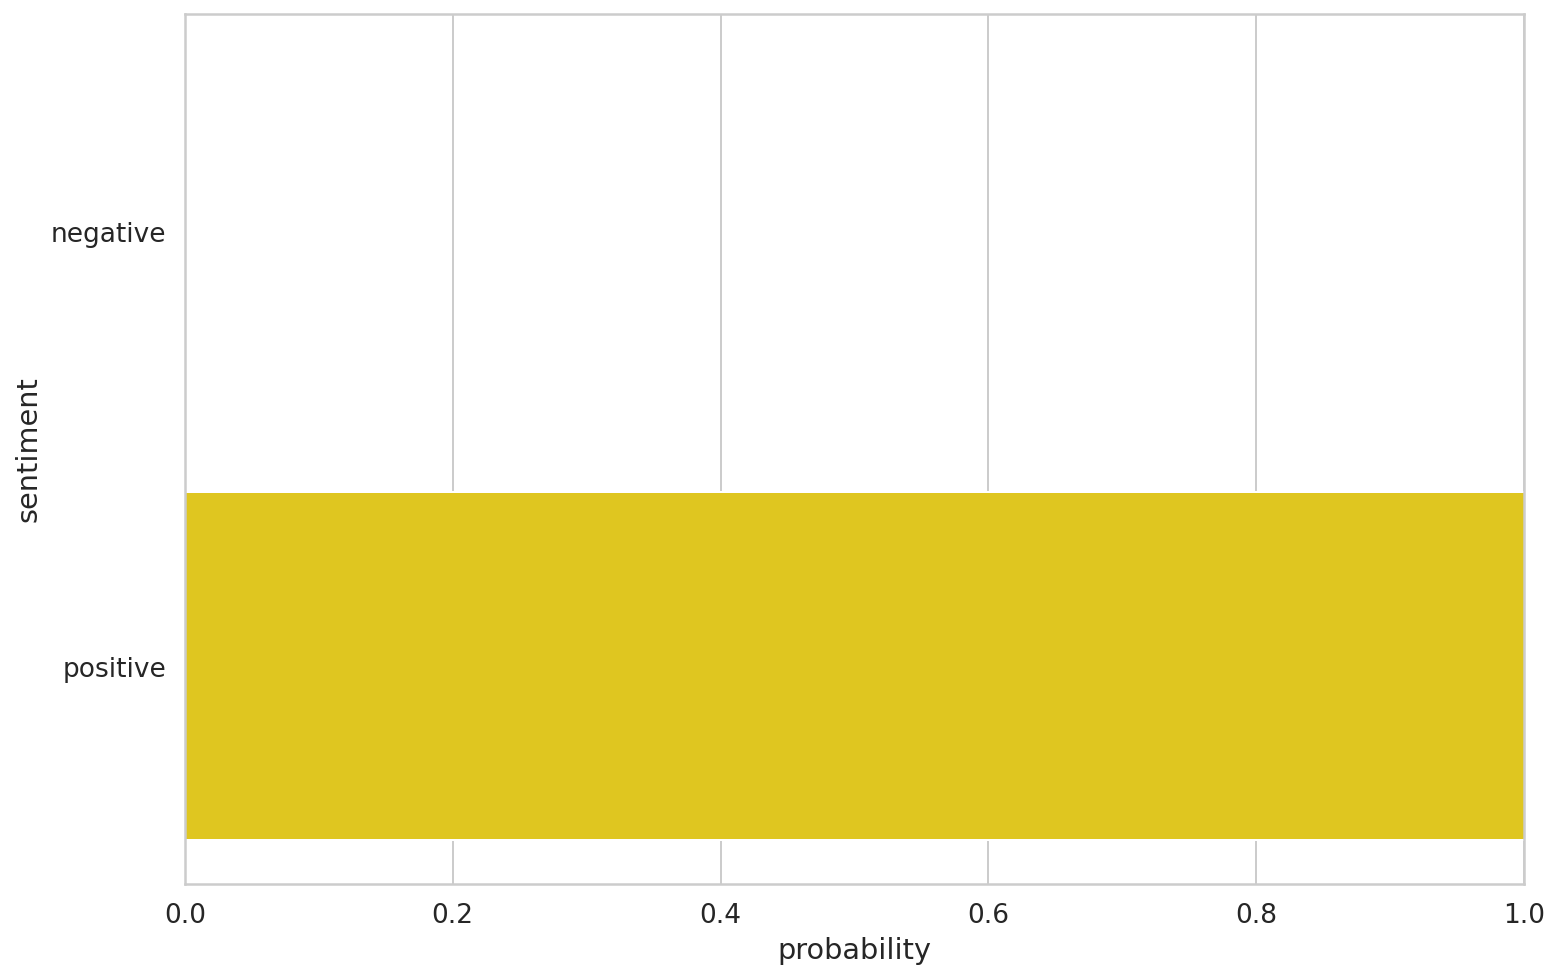

In [77]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [67]:
2+2

4